# Import librairies

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
pip install statsmodels --upgrade

     |████████████████████████████████| 9.8 MB 5.3 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [4]:
!apt-get install libsox-fmt-all libsox-dev sox > /dev/null
! python -m pip install torchaudio > /dev/null
! python -m pip install git+https://github.com/facebookresearch/WavAugment.git > /dev/null

  Running command git clone -q https://github.com/facebookresearch/WavAugment.git /tmp/pip-req-build-wxhgu4dj


In [5]:
!pip install ffmpeg-python > /dev/null

In [6]:
import torch
import pandas as  pd
import numpy as np
from pandas import read_csv
from matplotlib import pyplot
from pandas.plotting import lag_plot
from pandas import DataFrame
from pandas import concat
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
from math import sqrt


#Import Wave

In [7]:
import torchaudio
x, sr = torchaudio.load('/content/drive/MyDrive/xylophone.wav')
xn, srn = torchaudio.load('/content/drive/MyDrive/whitenoise.wav')

In [8]:
wave1 = pd.DataFrame(x.numpy())
wn = pd.DataFrame(xn.numpy())

In [9]:
wave1.to_csv('wave1.csv', index=False)
!cp wave1.csv "drive/My Drive"

In [10]:
wn.to_csv('wn.csv', index=False)
!cp wn.csv "drive/My Drive"

In [11]:
series = read_csv('wave1.csv', header=0, index_col=0)
series=series.T
seriesn = read_csv('wn.csv', header=0, index_col=0)
seriesn=seriesn.T
#print(series.head())
#series.plot()
#pyplot.show()

In [12]:
series

0,0.0
1,0.000000
2,0.000000
3,0.000000
4,0.000000
5,0.000000
...,...
349995,0.007538
349996,0.006775
349997,0.004852
349998,0.002014


In [13]:
n=(len(seriesn)-len(series))//2
seriesn=seriesn[n+1:len(seriesn)-n]

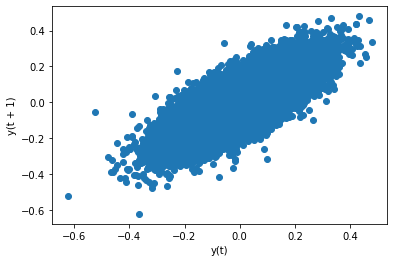

In [14]:
lag_plot(series)
pyplot.show()

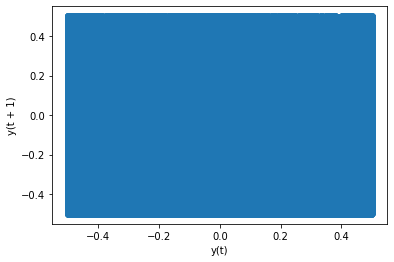

In [15]:
lag_plot(seriesn)
pyplot.show()

In [16]:
values = DataFrame(series.values)
dataframe = concat([values.shift(1), values], axis=1)
dataframe.columns = ['t-1', 't+1']
result = dataframe.corr()
print(result)

          t-1       t+1
t-1  1.000000  0.893285
t+1  0.893285  1.000000


#Train AR Model (without noise)

###Simple Model

Coefficients: [-7.23991212e-05  3.00430003e+00 -5.16366051e+00  6.94281501e+00
 -8.52847215e+00  1.00746541e+01 -1.16669469e+01  1.29333241e+01
 -1.39438222e+01  1.47918647e+01 -1.55077207e+01  1.58627891e+01
 -1.58816757e+01  1.54127831e+01 -1.46523374e+01  1.35752931e+01
 -1.22960386e+01  1.08146490e+01 -9.37396636e+00  7.91889144e+00
 -6.33303448e+00  4.69355990e+00 -3.31833729e+00  2.26332500e+00
 -1.52283871e+00  1.01396607e+00 -7.90081508e-01  7.23838785e-01
 -5.17369274e-01  1.50904439e-01]
predicted=0.004036, expected=0.001923
predicted=0.005659, expected=-0.001434
predicted=0.007662, expected=-0.005005
predicted=0.008440, expected=-0.008453
predicted=0.007442, expected=-0.011536
predicted=0.005246, expected=-0.013885
predicted=0.002727, expected=-0.015381
predicted=-0.000039, expected=-0.015839
predicted=-0.002998, expected=-0.015167
predicted=-0.005569, expected=-0.013428
predicted=-0.007001, expected=-0.010681
predicted=-0.007055, expected=-0.007202
predicted=-0.005999, expe

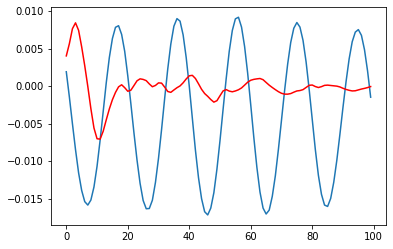

In [ ]:
# split dataset
X = series.values
train, test = X[1:len(X)-100], X[len(X)-100:]
# train autoregression
model = AutoReg(train, lags=15)
model_fit = model.fit()
print('Coefficients: %s' % model_fit.params)
# make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
for i in range(len(predictions)):
	print('predicted=%f, expected=%f' % (predictions[i], test[i]))
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot results
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

###Advanced Model

predicted=0.006295, expected=0.005920
predicted=0.008716, expected=0.007202
predicted=0.008076, expected=0.007538
predicted=0.008421, expected=0.006775
predicted=0.005709, expected=0.004852
predicted=0.003740, expected=0.002014
predicted=-0.000389, expected=-0.001465
Test RMSE: 0.001


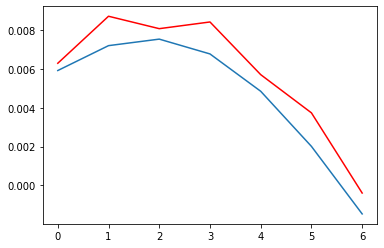

In [ ]:
# split dataset
X = series.values
train, test = X[1:len(X)-7], X[len(X)-7:]
# train autoregression
window = 15
model = AutoReg(train, lags=15)
model_fit = model.fit()
coef = model_fit.params
# walk forward over time steps in test
history = train[len(train)-window:]
history = [history[i] for i in range(len(history))]
predictions = list()
for t in range(len(test)):
	length = len(history)
	lag = [history[i] for i in range(length-window,length)]
	yhat = coef[0]
	for d in range(window):
		yhat += coef[d+1] * lag[window-d-1]
	obs = test[t]
	predictions.append(yhat)
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

#Train AR Model + Noise

###Simple Model

Coefficients: [-0.00093561  0.0494684   0.03083551  0.01569776  0.00248846 -0.00953661
 -0.01476804 -0.01795395 -0.02111057 -0.01679708 -0.016864   -0.0169976
 -0.01830517 -0.0183099  -0.01750728 -0.01522169]
predicted=0.046073, expected=0.001923
predicted=0.030470, expected=-0.001434
predicted=0.011886, expected=-0.005005
predicted=0.004869, expected=-0.008453
predicted=-0.007945, expected=-0.011536
predicted=-0.016225, expected=-0.013885
predicted=-0.020440, expected=-0.015381
predicted=-0.020942, expected=-0.015839
predicted=-0.018867, expected=-0.015167
predicted=-0.021049, expected=-0.013428
predicted=-0.021400, expected=-0.010681
predicted=-0.019217, expected=-0.007202
predicted=-0.017105, expected=-0.003387
predicted=-0.009002, expected=0.000458
predicted=-0.009152, expected=0.003815
predicted=-0.001476, expected=0.006348
predicted=0.000157, expected=0.007843
predicted=0.001330, expected=0.008057
predicted=0.001988, expected=0.006897
predicted=0.002333, expected=0.004639
predict

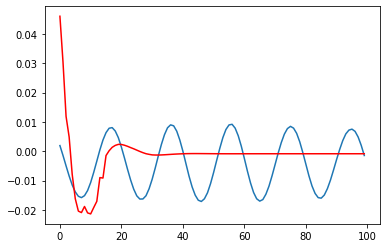

In [31]:
# split dataset
X = series.values + seriesn.values
train = X[1:len(X)-100]
X1 = series.values 
test= X1[len(X)-100:]
# train autoregression
model = AutoReg(train, lags=15)
model_fit = model.fit()
print('Coefficients: %s' % model_fit.params)
# make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
for i in range(len(predictions)):
	print('predicted=%f, expected=%f' % (predictions[i], test[i]))
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot results
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

###Advanced Model



predicted=0.046073, expected=0.001923
predicted=0.028286, expected=-0.001434
predicted=0.008947, expected=-0.005005
predicted=0.002357, expected=-0.008453
predicted=-0.009736, expected=-0.011536
predicted=-0.016737, expected=-0.013885
predicted=-0.019730, expected=-0.015381
predicted=-0.019284, expected=-0.015839
predicted=-0.016550, expected=-0.015167
predicted=-0.018674, expected=-0.013428
predicted=-0.018909, expected=-0.010681
predicted=-0.016546, expected=-0.007202
predicted=-0.014282, expected=-0.003387
predicted=-0.006052, expected=0.000458
predicted=-0.006457, expected=0.003815
predicted=0.001034, expected=0.006348
predicted=0.001519, expected=0.007843
predicted=0.001796, expected=0.008057
predicted=0.001831, expected=0.006897
predicted=0.001617, expected=0.004639
predicted=0.001177, expected=0.001373
predicted=0.000552, expected=-0.002319
predicted=-0.000185, expected=-0.006195
predicted=-0.000961, expected=-0.009827
predicted=-0.001696, expected=-0.012939
predicted=-0.002319,

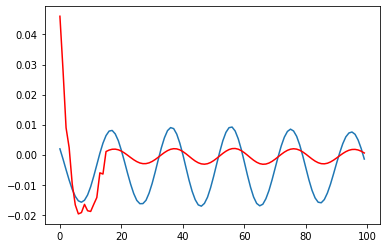

In [32]:
# split dataset
X = series.values + seriesn.values
train = X[1:len(X)-100]
X1 = series.values 
test= X1[len(X)-100:]
# train autoregression
window = 15
model = AutoReg(train, lags=15)
model_fit = model.fit()
coef = model_fit.params
# walk forward over time steps in test
history = train[len(train)-window:]
history = [history[i] for i in range(len(history))]
predictions = list()
for t in range(len(test)):
	length = len(history)
	lag = [history[i] for i in range(length-window,length)]
	yhat = coef[0]
	for d in range(window):
		yhat += coef[d+1] * lag[window-d-1]
	obs = test[t]
	predictions.append(yhat)
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

#Impact of the window (p)

###Simple Model

In [ ]:
# split dataset
X = series.values + seriesn.values
train = X[1:len(X)-100]
X1 = series.values 
test= X1[len(X)-100:]
# train autoregression
T=np.zeros([14,2])
j=0
for p in [5,10,15,20,25,30,35,40,45,50,55,60,65,70]:
	model = AutoReg(train, lags=p)
	model_fit = model.fit()
	#print('Coefficients: %s' % model_fit.params)
	# make predictions
	predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
	#for i in range(len(predictions)):
		#print('predicted=%f, expected=%f' % (predictions[i], test[i]))
	rmse = sqrt(mean_squared_error(test, predictions))
	T[j,0]=p
	T[j,1]=rmse
	j+=1
	#print('Test RMSE: %.3f' % rmse)
	#pyplot.plot(test)
	#pyplot.plot(predictions, color='red')
	#pyplot.show()
verification=pd.DataFrame(T,columns=['window','RMSE'])
verification = verification.astype({"window": int,'RMSE': float})
verification= verification.transpose() 
# plot results


In [ ]:
verification

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
window,5.00000,10.000000,15.000000,20.000000,25.000000,30.000000,35.000000,40.000000,45.000000,50.000000,55.000000,60.000000,65.000000,70.000000
RMSE,0.00981,0.009223,0.010852,0.011218,0.013677,0.013862,0.014613,0.015021,0.016912,0.017007,0.017245,0.017914,0.018386,0.017952


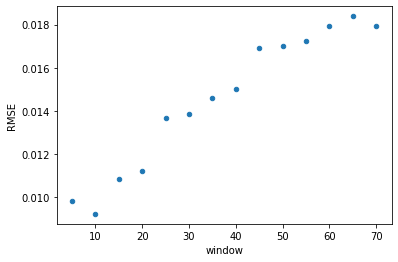

In [ ]:
verification.transpose().plot(kind='scatter',x='window',y='RMSE')

###Advanced Model

In [33]:
# split dataset
X = series.values + seriesn.values
train = X[1:len(X)-100]
X1 = series.values 
test= X1[len(X)-100:]
# train autoregression
T=np.zeros([14,2])
j=0
for p in [5,10,15,20,25,30,35,40,45,50,55,60,65,70]:
	window = p
	model = AutoReg(train, lags=p)
	model_fit = model.fit()
	coef = model_fit.params
	# walk forward over time steps in test
	history = train[len(train)-window:]
	history = [history[i] for i in range(len(history))]
	predictions = list()
	for t in range(len(test)):
		length = len(history)
		lag = [history[i] for i in range(length-window,length)]
		yhat = coef[0]
		for d in range(window):
			yhat += coef[d+1] * lag[window-d-1]
		obs = test[t]
		predictions.append(yhat)
		history.append(obs)
		#print('predicted=%f, expected=%f' % (yhat, obs))
	rmse = sqrt(mean_squared_error(test, predictions))
	T[j,0]=p
	T[j,1]=rmse
	j+=1
	#print('Test RMSE: %.3f' % rmse)
	# plot
	#pyplot.plot(test)
	#pyplot.plot(predictions, color='red')
	#pyplot.show()
	verification=pd.DataFrame(T,columns=['window','RMSE'])
	verification = verification.astype({"window": int,'RMSE': float})
	verification= verification.transpose() 

In [34]:
verification

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
window,5.000000,10.000000,15.000000,20.000000,25.000000,30.00000,35.00000,40.000000,45.000000,50.00000,55.000000,60.000000,65.000000,70.00000
RMSE,0.008979,0.008139,0.009431,0.009669,0.011308,0.01142,0.01147,0.011874,0.013278,0.01344,0.013627,0.013833,0.014323,0.01395


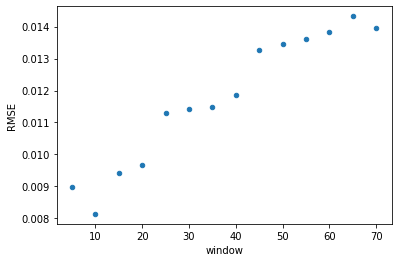

In [35]:
verification.transpose().plot(kind='scatter',x='window',y='RMSE')